## Elisa Malzoni

___
## Projeto 2-2: Contagem de Pessoas

**Motivação**: http://www.cvg.reading.ac.uk/PETS2009/a.html#s1

Objetivo: Vocês devem tentar realizar a contagem de pessoas no dataset S1.L1 utilizando o modelo de codebook. As imagens foram distribuídas via pendrive.

Requisitos:
  * Tem que usar o modelo de codebook do artigo.
  * A partir da separação do foreground, vocês podem utilizar qualquer método para realizar a contagem, incluindo Clustering ou Machine Learning.
  * O Repositório no Git deve conter além do código fonte, os dados do codebook treinado salvo com Pickle e um relatório do projeto.
  * O relatório deve conter a metodologia utilizada (incluindo treinamento) e comentário sobre os resultados obtidos.

### Entrega: 03/Out 23:59 via GitHub.

### Rubrica do Projeto:

    I. Não entregou ou entregou apenas um rascunho.
    D. Implementou parcialmente o artigo ou não realizou a contagem.
    C. Implementou a sessão 2 do artigo e realizou uma contagem de forma simples.
    B. Cumpriu a rubrica C com a implementação completa do codebook.
    A. Além de cumprir a rubrica B, realiza a contagem com uma técnica elaborada.
    
    -1 Conceito se o relatório estiver ausente ou insatisfatório.

In [74]:
%reset -f
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import pickle
from tqdm import tqdm
from PIL import Image


In [75]:
class Codeword():
    def __init__(self, v, aux):
        self.v = v
        self.aux = aux

In [76]:
def colordist(x, v): 
    normaxt2 = ((x[0]**2) + (x[1]**2) + (x[2]**2))
    normavi2 = v[0]**2 + v[1]**2 +v[2]**2
    tupxtvi2 = (v[0]*x[0] + v[1]*x[1] + v[2]*x[2])**2
    if normavi2 == 0:
        p2 = 0
    else:
        p2 = (tupxtvi2/normavi2)

    return math.sqrt(abs((normaxt2) - (p2)))


def brightness(xt, Imax, Imin):
    alpha = 0.4
    beta = 1.1
    Ilow = alpha* Imax
    Ihi = min(beta*Imax, Imin/alpha)
    normaxt= math.sqrt(xt[0]**2 + xt[1]**2 + xt[2]**2)
    if (Ilow <= normaxt and normaxt <= Ihi):
        return True
    return False

In [77]:
list_img = ["00000001.jpg","00000154.jpg","00000211.jpg","00000425.jpg","00000050.jpg","00000446.jpg","00000291.jpg"]
N = len(list_img)
img = cv2.imread("00000001.jpg")

C =[]
for i in range(img.shape[0]):
    C.append([])
    for j in range (img.shape[1]):
        C[i].append([])


E1 = 12

for t in tqdm(range(1, N+1)):
    # str_img = "../visao2_2/S0_BG/Crowd_PETS09/S0/Background/View_001/Time_13-06/" + list_img[t-1]

    img = cv2.imread(list_img[t-1])
    img = img.astype(float)
    for linha in range(img.shape[0]):
        for coluna in range(img.shape[1]):
            xt = img[linha, coluna, :]
            I = math.sqrt(xt[0]**2 + xt[1]**2 + xt[2]**2)
            match = False
            for cw in C[linha][coluna]:
                if (colordist(xt, cw.v) <= E1) and (brightness(xt, cw.aux[0],cw.aux[1])):
                    #atuliza codeword
                    fm = cw.v[2]
                    Rm = (fm*cw.v[0] + xt[0])/ (fm + 1)
                    Gm = (fm*cw.v[1] + xt[1])/ (fm + 1)
                    Bm = (fm*cw.v[2] + xt[2])/ (fm + 1)
                    cw.v = (Rm, Gm, Bm)
                    cw.aux[0] = min(I, cw.aux[0])
                    cw.aux[1] = max(I, cw.aux[1])
                    cw.aux[2] = fm + 1
                    cw.aux[3] = max(cw.aux[3], t - cw.aux[5])
                    cw.aux[4] = cw.aux[4] ### ???
                    cw.aux[5] = t
                    match = True

                    break

            if not match:
                newcw = Codeword(xt, [I, I, 1, t-1, t, t])
                
                C[linha][coluna].append(newcw)

    #atuliza lambda com for nos codewords
    for linha in range(img.shape[0]):
        for coluna in range(img.shape[1]):
            for cw in C[linha][coluna]:
                cw.aux[3] = max(cw.aux[3],(N - cw.aux[5] + cw.aux[4] - 1))
outfile = open('codebook.p', 'wb')
pickle.dump(C, outfile)
outfile.close()


100%|██████████| 7/7 [00:38<00:00,  6.09s/it]


In [78]:
infile = open("codebook.p",'rb')
C = pickle.load(infile)


In [79]:
C[0][0][0]

In [80]:
img = cv2.imread("frame_0000.jpg")
E2 = 8

0.0


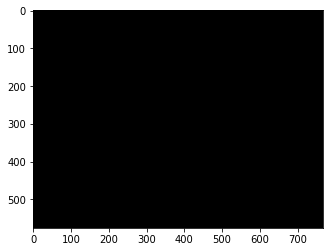

In [106]:
new = np.zeros((img.shape[0],img.shape[1]))
# new = cv2.cvtColor(new, cv2.COLOR_RGB2GRAY)
# new = Image.new("L", (img.shape[0], img.shape[1]))

print(new[0][0])


# rows, cols = new.shape
# new[(rows + 100)//2, (cols + 100)//2] = 1.0

# plt.figure(figsize=(6, 6))
plt.imshow(new, cmap = 'gray');
# new.show()

In [101]:
def BGS(xt):
    I = math.sqrt(xt[0]**2 + xt[1]**2 + xt[2]**2)
#     match = False
    for cw in C[linha][coluna]:
        if (colordist(xt, cw.v) <= E2) and (brightness(xt,cw.aux[0],cw.aux[1])):
            #atuliza codeword
            fm = cw.v[2]
            Rm = (fm*cw.v[0] + xt[0])/ (fm + 1)
            Gm = (fm*cw.v[1] + xt[1])/ (fm + 1)
            Bm = (fm*cw.v[2] + xt[2])/ (fm + 1)
            cw.v = (Rm, Gm, Bm)
            cw.aux[0] = min(I, cw.aux[0])
            cw.aux[1] = max(I, cw.aux[1])
            cw.aux[2] = fm + 1
#                 cw.aux[3] = max(cw.aux[3], t - cw.aux[5])
            cw.aux[4] = cw.aux[4] ### ???
#                 cw.aux[5] = t
#                     match = True
            return True
#                 print("entrou")
        return False

In [107]:
for linha in range(img.shape[0]):
    for coluna in range(img.shape[1]):
        match = BGS(img[linha][coluna])
        if match:
            new[linha,coluna] = 255.0



infile.close()

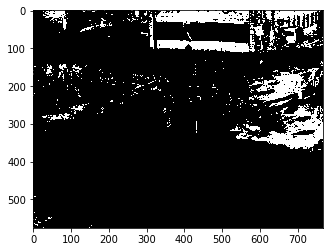

In [108]:
plt.imshow(new, cmap = 'gray')